# Library import

In [1]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer

In [2]:
userPATH = 'original_data/'
tweetPATH = 'DataWithNERConcat/tweetAgg/'

In [3]:
userlvltrain = pd.read_csv(userPATH+'/userlvltrain.csv')
userlvltest = pd.read_csv(userPATH+'/userlvltest.csv')
userlvlval = pd.read_csv(userPATH+'/userlvlval.csv')

In [4]:
train_df = pd.read_csv(tweetPATH+'aggtrain_df.csv')
train_df.rename(columns={'entityTweetsConcat':'text'}, inplace=True)
train_df['userLocation'] = userlvltrain.userLocation

test_df = pd.read_csv(tweetPATH+'aggtest_df.csv')
test_df['userLocation'] = userlvltest.userLocation
test_df.rename(columns={'entityTweetsConcat':'text'}, inplace=True)

val_df = pd.read_csv(tweetPATH+'aggval_df.csv')
val_df['userLocation'] = userlvlval.userLocation
val_df.rename(columns={'entityTweetsConcat':'text'}, inplace=True)

In [5]:
## prepare data for BERT training and save in newdata/
if not os.path.exists('newdata/'): 
    os.mkdir('newdata/')
    train_df.to_csv('newdata/train.csv', index=False)
    test_df.to_csv('newdata/test.csv', index=False)
    val_df.to_csv('newdata/dev.csv', index=False)

possible_labels = train_df.userLocation.unique()
possible_labels.sort()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
print(label_dict)
inv_label_dict = {v: k for k, v in label_dict.items()}
print(inv_label_dict)

{'bali dan nusa tenggara': 0, 'jabodetabek': 1, 'jawa barat dan banten': 2, 'jawa tengah dan yogyakarta': 3, 'jawa timur': 4, 'kalimantan': 5, 'maluku dan papua': 6, 'sulawesi': 7, 'sumatera': 8}
{0: 'bali dan nusa tenggara', 1: 'jabodetabek', 2: 'jawa barat dan banten', 3: 'jawa tengah dan yogyakarta', 4: 'jawa timur', 5: 'kalimantan', 6: 'maluku dan papua', 7: 'sulawesi', 8: 'sumatera'}


## Setting Cuda

In [6]:
!nvidia-smi

Thu Mar 24 02:29:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.126.02   Driver Version: 418.126.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   35C    P0    57W / 300W |  21209MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   45C    P0   155W / 300W |  13700MiB / 32480MiB |     90%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [7]:
torch.cuda.set_device(7)
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
device_idx = "cuda:7"
torch.cuda.current_device()

7

In [8]:
import random 
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

def location_prediction_metrics(list_hyp, list_label):
    metrics = {}
    metrics["ACC"] = accuracy_score(list_label, list_hyp)
    metrics["F1"] = f1_score(list_label, list_hyp, average='macro')
    metrics["REC"] = recall_score(list_label, list_hyp, average='macro')
    metrics["PRE"] = precision_score(list_label, list_hyp, average='macro')
    return metrics


class LocationPredictionDataset(Dataset):
    # Static constant variable
    LABEL2INDEX = label_dict
    INDEX2LABEL = inv_label_dict
    NUM_LABELS = 9
    
    def load_dataset(self, path): 
        df = pd.read_csv(path, sep=',')
        # df.columns = ['screenName','tweets','userLocation', 'mentionedLocation','label', 'final_feat']
        df['userLocation'] = df['userLocation'].apply(lambda lab: self.LABEL2INDEX[lab])
        return df
    
    def __init__(self, dataset_path, tokenizer, no_special_token=False, *args, **kwargs):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token
    
    def __getitem__(self, index):
        data = self.data.loc[index,:]
        tweets, labels = data['text'], data['userLocation']
        subwords = self.tokenizer.encode(tweets, add_special_tokens=not self.no_special_token)
        return np.array(subwords), np.array(labels), data['text']
    
    def __len__(self):
        return len(self.data)    
        
class LocationPredictionDataLoader(DataLoader):
    def __init__(self, max_seq_len=512, *args, **kwargs):
        super(LocationPredictionDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len
        
    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)
        
        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        class_batch = np.zeros((batch_size, 1), dtype=np.int64)
        
        seq_list = []
        for i, (subwords, tagging, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i,:len(subwords)] = subwords
            mask_batch[i,:len(subwords)] = 1
            class_batch[i,0] = tagging
            
            seq_list.append(raw_seq)
            
        return subword_batch, mask_batch, class_batch, seq_list

# Forward function for sequence classification
def forward_sequence_classification(model, batch_data, i2w, is_test=False, device='cpu', **kwargs):
    # Unpack batch data
    if len(batch_data) == 3:
        (subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 4:
        (subword_batch, mask_batch, token_type_batch, label_batch) = batch_data
    
    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch)
    mask_batch = torch.FloatTensor(mask_batch)
    token_type_batch = torch.LongTensor(token_type_batch) if token_type_batch is not None else None
    label_batch = torch.LongTensor(label_batch)
            
    if device == device_idx:
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = token_type_batch.cuda() if token_type_batch is not None else None
        label_batch = label_batch.cuda()

    # Forward model
    outputs = model(subword_batch, attention_mask=mask_batch, token_type_ids=token_type_batch, labels=label_batch)
    loss, logits = outputs[:2]
    
    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = torch.topk(logits, 1)[1]
    for j in range(len(hyp)):
        list_hyp.append(i2w[hyp[j].item()])
        list_label.append(i2w[label_batch[j][0].item()])
        
    return loss, list_hyp, list_label

# Save and Load Functions

# pada fungsi ini dilakukan penyimpanan model, optimizer, dan validation loss
def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)

# untuk meload loss yang telah disimpan
def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']

# pada fungsi ini accuracy dan loss disimpan 
def save_metrics(save_path, train_acc_list, train_loss_list, valid_acc_list, valid_loss_list, epochs):

    if save_path == None:
        return
    
    state_dict = {'train_acc_list': train_acc_list,
                  'train_loss_list': train_loss_list,
                  'valid_acc_list': valid_acc_list,
                  'valid_loss_list': valid_loss_list,
                  'epochs_list': epochs}
    
    torch.save(state_dict, save_path)
    # print(f'Model saved to ==> {save_path}')

# fungsi untuk melakukan load accuracy dan loss 
def load_metrics(load_path): 

    if load_path==None:
        return
    state_dict = torch.load(load_path)    
    
    return state_dict['train_acc_list'],state_dict['train_loss_list'], state_dict['valid_acc_list'], state_dict['valid_loss_list'], state_dict['epochs_list']

## Prepare Dataset

In [9]:
set_seed(42)

#Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1',
                                    attention_probs_dropout_prob=0.3,
                                    hidden_dropout_prob=0.3)
config.num_labels = LocationPredictionDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', 
                                                      config=config)

train_dataset = LocationPredictionDataset("newdata/train.csv", tokenizer, lowercase=True)
valid_dataset = LocationPredictionDataset("newdata/dev.csv", tokenizer, lowercase=True)
test_dataset = LocationPredictionDataset("newdata/test.csv", tokenizer, lowercase=True)


learning_rate = 2e-5
batch_size = 16
epochs = 7

train_loader = LocationPredictionDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=batch_size, num_workers=16, shuffle=True)  
valid_loader = LocationPredictionDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=batch_size, num_workers=16, shuffle=False)  
test_loader = LocationPredictionDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=batch_size, num_workers=16, shuffle=False)

HTTPError: 500 Server Error: Internal Server Error for url: https://huggingface.co/indobenchmark/indobert-base-p1/resolve/main/vocab.txt

In [12]:
w2i, i2w = LocationPredictionDataset.LABEL2INDEX, LocationPredictionDataset.INDEX2LABEL
print(w2i, '\n', i2w)

{'bali dan nusa tenggara': 0, 'jabodetabek': 1, 'jawa barat dan banten': 2, 'jawa tengah dan yogyakarta': 3, 'jawa timur': 4, 'kalimantan': 5, 'maluku dan papua': 6, 'sulawesi': 7, 'sumatera': 8} 
 {0: 'bali dan nusa tenggara', 1: 'jabodetabek', 2: 'jawa barat dan banten', 3: 'jawa tengah dan yogyakarta', 4: 'jawa timur', 5: 'kalimantan', 6: 'maluku dan papua', 7: 'sulawesi', 8: 'sumatera'}


## Fine Tuning and Evaluation

In [13]:
torch.cuda.empty_cache()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
model = model.to(device)

In [15]:
file_path = 'saved_model_agg/'
if not os.path.exists(file_path): 
    os.mkdir(file_path)

model_name = 'indoNLU_model'
metrics_name = 'indoNLU_metrics'

model_path = file_path+model_name+'_'+str(batch_size)+'_'+str(epochs)+'_'+str(learning_rate)+'.pt'
metrics_path = file_path+metrics_name+'_'+str(batch_size)+'_'+str(epochs)+'_'+str(learning_rate)+'.pt'

### training

In [13]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# list untuk menyimpan data metrics setiap training, untuk memudahkan 
# menampilkan dalam grafik
train_acc_list = [] 
train_loss_list = []
valid_acc_list = [] 
valid_loss_list = []
epochs_list = []

best_valid_loss = float("Inf")

# Train
n_epochs = epochs
for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))

    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, 
                                                                       device=device_idx)

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = location_prediction_metrics(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
    
    train_loss_list.append(total_train_loss/(i+1))
    train_acc_list.append(metrics['ACC'])
    epochs_list.append(epoch)


    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))

    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, 
                                                                       device=device_idx)
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = location_prediction_metrics(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = location_prediction_metrics(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    
    valid_loss_list.append(total_loss/(i+1))
    valid_acc_list.append(metrics['ACC'])

    # checkpoint, untuk menyimpan validation loss dan metrics yang paling baik untuk seluruh epochs 
    if best_valid_loss > total_loss/(i+1):
      best_valid_loss = total_loss/(i+1)
      save_checkpoint(model_path, model, optimizer, best_valid_loss)

save_metrics(metrics_path, train_acc_list, train_loss_list, valid_acc_list, valid_loss_list, epochs_list)
print('Done Training!')

(Epoch 1) TRAIN LOSS:2.2472 LR:0.00002000: 100%|██████████| 57/57 [00:29<00:00,  1.92it/s]


(Epoch 1) TRAIN LOSS:2.2472 ACC:0.13 F1:0.10 REC:0.11 PRE:0.12 LR:0.00002000


  0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.0947 ACC:0.31 F1:0.06 REC:0.12 PRE:0.04:  14%|█▍        | 1/7 [00:01<00:08,  1.49s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.2230 ACC:0.22 F1:0.04 REC:0.11 PRE:0.02:  29%|██▊       | 2/7 [00:01<00:03,  1.40it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no p

(Epoch 1) VALID LOSS:2.1986 ACC:0.13 F1:0.03 REC:0.11 PRE:0.01


(Epoch 2) TRAIN LOSS:2.1961 LR:0.00002000: 100%|██████████| 57/57 [00:29<00:00,  1.92it/s]


(Epoch 2) TRAIN LOSS:2.1961 ACC:0.13 F1:0.11 REC:0.12 PRE:0.12 LR:0.00002000


  0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:2.1933 ACC:0.19 F1:0.09 REC:0.15 PRE:0.07:  14%|█▍        | 1/7 [00:01<00:09,  1.51s/it]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

(Epoch 2) VALID LOSS:2.2836 ACC:0.12 F1:0.07 REC:0.13 PRE:0.04


(Epoch 3) TRAIN LOSS:1.8874 LR:0.00002000: 100%|██████████| 57/57 [00:29<00:00,  1.94it/s]


(Epoch 3) TRAIN LOSS:1.8874 ACC:0.32 F1:0.33 REC:0.32 PRE:0.37 LR:0.00002000


  0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.5223 ACC:0.61 F1:0.61 REC:0.61 PRE:0.64: 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


(Epoch 3) VALID LOSS:1.5223 ACC:0.61 F1:0.61 REC:0.61 PRE:0.64


(Epoch 4) TRAIN LOSS:1.0730 LR:0.00002000: 100%|██████████| 57/57 [00:29<00:00,  1.91it/s]


(Epoch 4) TRAIN LOSS:1.0730 ACC:0.71 F1:0.72 REC:0.71 PRE:0.73 LR:0.00002000


  0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.0202 ACC:0.74 F1:0.73 REC:0.74 PRE:0.74: 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


(Epoch 4) VALID LOSS:1.0202 ACC:0.74 F1:0.73 REC:0.74 PRE:0.74


(Epoch 5) TRAIN LOSS:0.7129 LR:0.00002000: 100%|██████████| 57/57 [00:29<00:00,  1.94it/s]


(Epoch 5) TRAIN LOSS:0.7129 ACC:0.80 F1:0.81 REC:0.80 PRE:0.82 LR:0.00002000


  0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.0643 ACC:0.71 F1:0.72 REC:0.71 PRE:0.73: 100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


(Epoch 5) VALID LOSS:1.0643 ACC:0.71 F1:0.72 REC:0.71 PRE:0.73


(Epoch 6) TRAIN LOSS:0.4791 LR:0.00002000: 100%|██████████| 57/57 [00:29<00:00,  1.92it/s]


(Epoch 6) TRAIN LOSS:0.4791 ACC:0.87 F1:0.87 REC:0.87 PRE:0.88 LR:0.00002000


  0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.1729 ACC:0.71 F1:0.70 REC:0.71 PRE:0.71: 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]


(Epoch 6) VALID LOSS:1.1729 ACC:0.71 F1:0.70 REC:0.71 PRE:0.71


(Epoch 7) TRAIN LOSS:0.3482 LR:0.00002000: 100%|██████████| 57/57 [00:29<00:00,  1.94it/s]


(Epoch 7) TRAIN LOSS:0.3482 ACC:0.91 F1:0.91 REC:0.91 PRE:0.91 LR:0.00002000


  0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:1.1965 ACC:0.72 F1:0.72 REC:0.72 PRE:0.73: 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]

(Epoch 7) VALID LOSS:1.1965 ACC:0.72 F1:0.72 REC:0.72 PRE:0.73
Done Training!


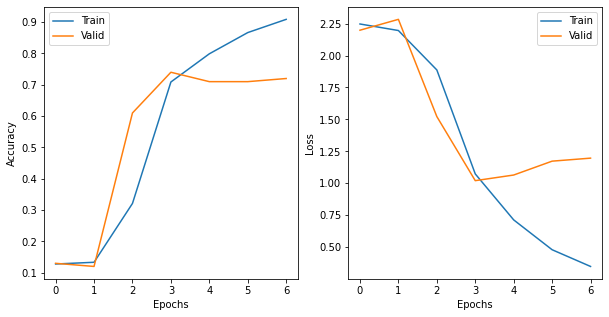

In [16]:
#  ## menampilkan history metrics akurasi dan loss 
import matplotlib.pyplot as plt

train_acc_list, train_loss_list, valid_acc_list, valid_loss_list, epochs_list = load_metrics(metrics_path)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.plot(epochs_list, train_acc_list, label='Train')
ax1.plot(epochs_list, valid_acc_list, label='Valid')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs_list, train_loss_list, label='Train')
ax2.plot(epochs_list, valid_loss_list, label='Valid')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
plt.show() 

### predict

In [17]:
set_seed(42)

#Load model
mytokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

myconfig = BertConfig.from_pretrained('indobenchmark/indobert-base-p1',
                                    attention_probs_dropout_prob=0.3,
                                    hidden_dropout_prob=0.3)
myconfig.num_labels = LocationPredictionDataset.NUM_LABELS

# Instantiate model
mymodel = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', 
                                                      config=myconfig)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# menggunakan gpu
best_model = mymodel.to(device)

optimizer = optim.AdamW(best_model.parameters(), lr=2e-5)

load_checkpoint(model_path, best_model, optimizer)

best_model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(best_model, batch_data[:-1], i2w=i2w, device=device_idx)
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()

100%|██████████| 16/16 [00:07<00:00,  2.21it/s]


In [19]:
## get y_test for user level
y_test_user_lvl = userlvltest.Lvalue
y_test_user_lvl.values

array([8, 6, 3, 0, 4, 1, 7, 4, 5, 1, 1, 7, 3, 5, 7, 0, 2, 4, 4, 2, 6, 2,
       7, 4, 2, 2, 1, 3, 2, 3, 1, 4, 1, 8, 2, 0, 1, 8, 6, 1, 8, 2, 2, 1,
       7, 4, 2, 3, 6, 0, 3, 4, 4, 3, 1, 5, 4, 0, 0, 2, 0, 4, 0, 3, 3, 3,
       7, 5, 7, 3, 3, 7, 3, 3, 3, 8, 3, 1, 6, 6, 5, 8, 5, 0, 1, 3, 7, 0,
       4, 8, 6, 0, 4, 2, 1, 5, 2, 5, 7, 8, 8, 6, 2, 4, 5, 4, 0, 7, 1, 2,
       0, 1, 8, 3, 8, 2, 0, 8, 4, 0, 4, 8, 2, 7, 3, 7, 2, 5, 6, 3, 3, 3,
       0, 4, 4, 0, 4, 8, 3, 2, 1, 1, 7, 6, 5, 5, 3, 1, 3, 6, 7, 8, 6, 5,
       2, 0, 2, 6, 1, 6, 8, 0, 7, 7, 1, 0, 4, 8, 8, 0, 6, 2, 4, 6, 4, 2,
       4, 8, 3, 1, 3, 6, 1, 6, 3, 8, 8, 1, 6, 0, 5, 8, 8, 3, 1, 2, 8, 2,
       0, 1, 2, 0, 4, 6, 2, 2, 6, 4, 0, 5, 6, 5, 4, 8, 5, 4, 7, 4, 3, 5,
       3, 8, 5, 2, 6, 8, 8, 5, 4, 4, 3, 7, 5, 2, 3, 0, 8, 1, 2, 1, 3, 4,
       1, 7, 4, 2, 5, 4, 3, 3])

In [20]:
## get y_pred for tweets level
y_pred_tweets_lvl = df.iloc[:,1].astype('category')
y_pred_tweets_lvl = y_pred_tweets_lvl.cat.codes
y_pred_tweets_lvl.values

array([2, 3, 4, 0, 4, 1, 7, 4, 5, 2, 1, 7, 3, 5, 7, 0, 2, 1, 4, 2, 6, 2,
       7, 4, 2, 2, 2, 3, 3, 3, 2, 3, 1, 8, 2, 0, 1, 8, 6, 1, 8, 2, 2, 5,
       7, 3, 2, 3, 6, 0, 3, 4, 4, 1, 1, 5, 4, 0, 1, 2, 0, 4, 0, 3, 3, 3,
       4, 5, 7, 3, 3, 7, 3, 3, 3, 4, 3, 4, 6, 6, 5, 8, 5, 1, 1, 3, 7, 0,
       0, 8, 6, 0, 3, 2, 5, 5, 2, 2, 7, 1, 2, 6, 2, 4, 0, 4, 3, 5, 1, 2,
       0, 2, 3, 3, 8, 2, 0, 8, 4, 0, 4, 8, 2, 7, 3, 1, 2, 5, 6, 3, 3, 3,
       2, 4, 4, 4, 4, 8, 3, 2, 1, 1, 7, 8, 5, 5, 3, 1, 6, 6, 7, 2, 6, 5,
       2, 6, 0, 6, 1, 6, 8, 0, 7, 4, 1, 0, 4, 8, 1, 3, 6, 4, 4, 6, 1, 1,
       3, 8, 3, 2, 3, 6, 2, 6, 3, 8, 1, 7, 6, 0, 5, 1, 8, 3, 1, 8, 8, 2,
       0, 1, 2, 0, 4, 6, 2, 2, 6, 4, 0, 4, 6, 5, 0, 8, 4, 4, 7, 4, 1, 3,
       2, 8, 5, 2, 6, 3, 8, 8, 4, 4, 2, 1, 7, 2, 3, 0, 8, 1, 2, 5, 3, 4,
       1, 7, 3, 2, 5, 4, 3, 3], dtype=int8)

In [21]:
from sklearn.metrics import classification_report, accuracy_score

## print classification report for user level prediction
print('accuracy %s' % round(accuracy_score(y_test_user_lvl, y_pred_tweets_lvl),2 ))
print(classification_report(y_test_user_lvl, y_pred_tweets_lvl,target_names=label_dict.keys()))

accuracy 0.75
                            precision    recall  f1-score   support

    bali dan nusa tenggara       0.83      0.73      0.78        26
               jabodetabek       0.57      0.61      0.59        28
     jawa barat dan banten       0.68      0.84      0.75        32
jawa tengah dan yogyakarta       0.71      0.83      0.77        36
                jawa timur       0.74      0.74      0.74        34
                kalimantan       0.79      0.68      0.73        22
          maluku dan papua       0.91      0.91      0.91        23
                  sulawesi       0.88      0.75      0.81        20
                  sumatera       0.86      0.66      0.75        29

                  accuracy                           0.75       250
                 macro avg       0.77      0.75      0.76       250
              weighted avg       0.76      0.75      0.75       250



In [20]:
y_pred_tweets_lvl.to_csv('bert_result/indoNLU2e_5Results.csv')

### Example of correctly classified data

In [22]:
userlvltest

,username,isaPerson,userLocation,screen_name,Lvalue
0,@arshere,person,sumatera,arshere,8
1,@inyormain,person,maluku dan papua,inyormain,6
2,@ainssdyh,person,jawa tengah dan yogyakarta,ainssdyh,3
3,@aline_adita,person,bali dan nusa tenggara,aline_adita,0
4,@Arnaz_Asa,person,jawa timur,Arnaz_Asa,4
...,...,...,...,...,...
245,@alfunmart,person,jawa barat dan banten,alfunmart,2
246,@DanarSN,person,kalimantan,DanarSN,5
247,@aminollahmimink,person,jawa timur,aminollahmimink,4
248,@StandUpSOLO,nonperson,jawa tengah dan yogyakarta,StandUpSOLO,3


In [23]:
result_table = pd.DataFrame()
result_table['tweets'] = test_df.text
result_table['username'] = userlvltest.username
result_table['predicted'] = y_pred_tweets_lvl
result_table['true_value'] = y_test_user_lvl

In [24]:
result_table[result_table['true_value']==0] 

,tweets,username,predicted,true_value
3,hi haru rabu jam siang jakarta wednesday lunch...,@aline_adita,0,0
15,disaat produktif penghargaan pergi berlibur me...,@westinbali,0,0
35,keluarga lpmp provinsi nusa tenggara timur sel...,@nttlpmp,0,0
49,direktur lintas polda ntb kombes pol djoni wid...,@RTMCPoldaNTB,0,0
57,meet amp feed the meerkat gang members in bali...,@BaliSafari,0,0
58,review cream wajah scarlett whitening nihhh yg...,@litarianti,1,0
60,mengirim foto smp negeri singaraja takut menco...,@DediMetrawan1,0,0
62,coba potong komen stress ngga eh aquarium anco...,@mahananda_,0,0
83,diaz gemes bangettt naka selamat yaaa kak cynd...,@atnisay,1,0
87,mengirim foto east nusa tenggara mengirim foto...,@kiko_henuk,0,0


In [26]:
text  = result_table[result_table['username']=='@StandupindoBali'].tweets.values[0]
text = text.split()
mylist = text[:512] 
str.join(" ", mylist)

'selamat natal tementemen merayakan yook ngajak gebetan traktir makan monggo gasss nonton diroasting ama kamis besok lupa dateng krn kursi terbatas terima kasih menghampiri umat lucu bali jumpa event terima kasih kepercayaan semoga ketemu event amaan bli mantaap siip uda book tiket hell suksma bli siaap bli yg hell heaven x show jam wita silahkan ditonton like subscribe bentuk perayaan komunitas terima kasih teaser tipistipis kejutan besok channel youtube selamat dekade terima kasih keluarga stand up indo terima kasih komika terima kasih penonton setia terima kasih yok nonton special show trus bernyanyi komikakomika minggu november jam sore dipandu tunggu kejutan dihibur ama komikakomika lokal yg gerrrrrrr kangen nonton stand up comedy yuk dateng no mask no entry line up bali langsung sikat tiketnya ini ulahnya kalo dapet bentukkan kek gini gimana kelean gaess squidgamenetflix selamat ulang tercinta terima kasih rumah komika penikmat stand up comedy viva la komtung thstandupindo dekade

In [27]:
text  = result_table[result_table['username']=='@dinkesbali'].tweets.values[0]
text = text.split()
mylist = text[:512] 
str.join(" ", mylist)

'ayo lakukan cuci tangan pakai sabun ctps salah upaya pencegahan covid bali perangi covid sekala niskala lembaga menyumbang apd penanganan covid pekerja migran bali dikarantinakan satgas bencana diskes sigap bantu pencegahan covid bali siapkan logistik darurat covid rapat tim kesiapsiagaan bencana dinas kesehatan waspadai coronavirus covid kenali penyebabnya lakukan pencegahannya wagub sekda penyemprotan disinfektan cegah covid gencarkan sosialisasi covid diskes bali undang pbf samakan persepsi terkait pkrs diskes bali undang pengelola pkrs kabupatenkota rakor diskes bali terkait perlindungan pendampingan hukum rs cegah stunting dinas kesehatan gelar pmba diskes dukung layanan tambahan jknkbs krama bali jajaran kesehatan tanggap covid waspada covid jajaran pemprov bali lakukan gerakan hygiene sanitasi lingkungan langkah siaga covid diskes bali diskes bali gelar workshop asdk sosialisasi sip rapat khusus siaga corona diskes bali diskes adakan forum pd sinkronkan rencana kegiatan kunjung

### create confusion matrix 

In [32]:
cm_names = {
    0:'NU',
    1:'JBD',
    2:'JB&BT',
    3:'JT&YO',
    4:'JI',
    5:'KA',
    6:'ML&PP',
    7:'SL',
    8:'SM'
}

cm_names_sorted = dict(sorted(cm_names.items(), key=lambda item: item[1]))

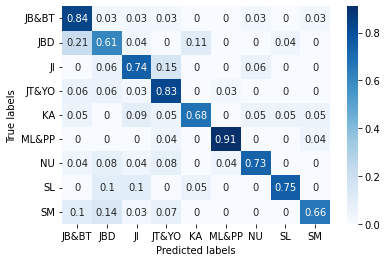

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf = confusion_matrix(y_test_user_lvl.values, y_pred_tweets_lvl.values, labels=list(cm_names_sorted.keys()))

conf_norm= np.around(conf.astype('float') / conf.sum(axis=1)[:, np.newaxis], decimals=2)


df_cm = pd.DataFrame(conf_norm, index = [i for i in cm_names_sorted.values()],
                    columns = [i for i in cm_names_sorted.values()])

plt.figure(figsize = (6,4))
ax= plt.subplot()
sns.heatmap(df_cm, annot=True,  cmap='Blues')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
plt.show()

In [34]:
conf.diagonal()/conf.sum(axis=1)

array([0.84375   , 0.60714286, 0.73529412, 0.83333333, 0.68181818,
       0.91304348, 0.73076923, 0.75      , 0.65517241])

## Test person to ALL 

In [35]:
set_seed(42)

#Load model
mytokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

myconfig = BertConfig.from_pretrained('indobenchmark/indobert-base-p1',
                                    attention_probs_dropout_prob=0.3,
                                    hidden_dropout_prob=0.3)
myconfig.num_labels = LocationPredictionDataset.NUM_LABELS

# Instantiate model
mymodel = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', 
                                                      config=myconfig)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
# menggunakan gpu
best_model = mymodel.to(device)

optimizer = optim.AdamW(best_model.parameters(), lr=2e-5)

file_path = 'person_saved_model'

load_checkpoint(file_path + '/indoNLU_model_2e_5_batch16.pt', best_model, optimizer)

best_model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(best_model, batch_data[:-1], i2w=i2w, device=device_idx)
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()

100%|██████████| 16/16 [00:04<00:00,  3.63it/s]


In [37]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report


## get y_pred for tweets level
y_pred_tweets_lvl_person = df.iloc[:,1].astype('category')
y_pred_tweets_lvl_person = y_pred_tweets_lvl_person.cat.codes


## print classification report for user level prediction
print('accuracy %s' % round(accuracy_score(userlvltest.Lvalue, y_pred_tweets_lvl_person),2 ))
print(classification_report(userlvltest.Lvalue, y_pred_tweets_lvl_person,target_names=label_dict.keys()))

accuracy 0.58
                            precision    recall  f1-score   support

    bali dan nusa tenggara       0.58      0.73      0.64        26
               jabodetabek       0.50      0.50      0.50        28
     jawa barat dan banten       0.68      0.41      0.51        32
jawa tengah dan yogyakarta       0.43      0.81      0.56        36
                jawa timur       0.60      0.26      0.37        34
                kalimantan       0.65      0.77      0.71        22
          maluku dan papua       0.75      0.78      0.77        23
                  sulawesi       0.65      0.65      0.65        20
                  sumatera       0.72      0.45      0.55        29

                  accuracy                           0.58       250
                 macro avg       0.62      0.60      0.58       250
              weighted avg       0.61      0.58      0.57       250



## Test nonperson to ALL

In [39]:
set_seed(42)

#Load model
mytokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

myconfig = BertConfig.from_pretrained('indobenchmark/indobert-base-p1',
                                    attention_probs_dropout_prob=0.3,
                                    hidden_dropout_prob=0.3)
myconfig.num_labels = LocationPredictionDataset.NUM_LABELS

# Instantiate model
mymodel = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', 
                                                      config=myconfig)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
# menggunakan gpu
best_model = mymodel.to(device)

optimizer = optim.AdamW(best_model.parameters(), lr=2e-5)

file_path = 'nonperson_saved_model'

load_checkpoint(file_path + '/indoNLU_model_2e_5_batch16.pt', best_model, optimizer)

best_model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(best_model, batch_data[:-1], i2w=i2w, device=device_idx)
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()

100%|██████████| 16/16 [00:04<00:00,  3.51it/s]


In [41]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report


## get y_pred for tweets level
y_pred_tweets_lvl_nonperson = df.iloc[:,1].astype('category')
y_pred_tweets_lvl_nonperson = y_pred_tweets_lvl_nonperson.cat.codes


## print classification report for user level prediction
print('accuracy %s' % round(accuracy_score(userlvltest.Lvalue, y_pred_tweets_lvl_nonperson),2 ))
print(classification_report(userlvltest.Lvalue, y_pred_tweets_lvl_nonperson,target_names=label_dict.keys()))

accuracy 0.68
                            precision    recall  f1-score   support

    bali dan nusa tenggara       0.86      0.73      0.79        26
               jabodetabek       0.32      0.68      0.43        28
     jawa barat dan banten       0.71      0.62      0.67        32
jawa tengah dan yogyakarta       0.72      0.72      0.72        36
                jawa timur       0.84      0.62      0.71        34
                kalimantan       0.71      0.68      0.70        22
          maluku dan papua       0.84      0.91      0.87        23
                  sulawesi       0.87      0.65      0.74        20
                  sumatera       0.94      0.59      0.72        29

                  accuracy                           0.68       250
                 macro avg       0.76      0.69      0.71       250
              weighted avg       0.75      0.68      0.70       250

